In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('data/dailyStats.csv',parse_dates=['datetime'],index_col='datetime')
df.drop(['sr# '], axis=1, inplace=True)
#remove column wih null values
df = df[df.columns[~df.isnull().all()]]
df

,new_cases
datetime,
2020-03-17,25
2020-02-26,1
2020-03-15,2
2020-03-18,9
2020-03-14,1
...,...
2022-08-21,808
2022-08-22,373
2022-08-23,177


In [3]:
train = df[df.index < '2022-03-01']
test = df[df.index >= '2022-03-01']
print(train.shape, test.shape)

(755, 1) (143, 1)


In [7]:
test.index.max()

Timestamp('2022-08-25 00:00:00')

/home/vscode/miniconda3/envs/stat/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vscode/miniconda3/envs/stat/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vscode/miniconda3/envs/stat/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


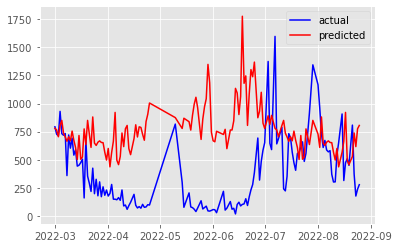

In [4]:
# exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
et = ExponentialSmoothing(train['new_cases'], seasonal_periods=100,  seasonal='add',use_boxcox=True).fit()
pred = et.predict(start=len(train), end=len(train)+len(test)-1)
pred = pd.DataFrame(pred.values, index=test.index, columns=['new_cases'])
plt.plot(test, label='actual', color='blue')
plt.plot(pred, label='predicted', color='red')
plt.legend()
plt.show()

In [5]:
# rmse
rmse = np.sqrt(mean_squared_error(test['new_cases'], pred['new_cases']))
print("RMSE: %.2f" % rmse)

RMSE: 559.59


/home/vscode/miniconda3/envs/stat/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vscode/miniconda3/envs/stat/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vscode/miniconda3/envs/stat/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vscode/miniconda3/envs/stat/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

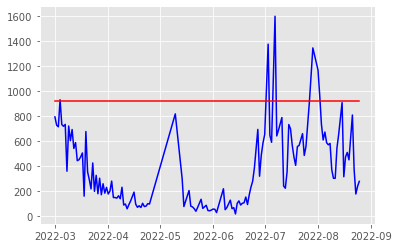

In [6]:
# arima 
from statsmodels.tsa.arima.model import ARIMA
arima = ARIMA(train['new_cases'], order=(0,1,1))
arima_fit = arima.fit()
pred = arima_fit.predict(start=len(train), end=len(train)+len(test)-1)
pred = pd.DataFrame(pred.values, index=test.index, columns=['new_cases'])
plt.plot(test, label='actual', color='blue')
plt.plot(pred, label='predicted', color='red')

In [7]:
# auto arima
from pmdarima import auto_arima
arima = auto_arima(train['new_cases'], start_p=1, start_q=1,max_p=5, max_q=5, trace=False, error_action='ignore', suppress_warnings=True)
arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  755
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -6151.585
Date:                Sat, 27 Aug 2022   AIC                          12307.169
Time:                        08:03:59   BIC                          12316.420
Sample:                             0   HQIC                         12310.733
                                - 755                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5686      0.017    -34.453      0.000      -0.601      -0.536
sigma2      7.235e+05   1.13e+04     64.200      0.000    7.01e+05    7.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):             15531.88
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             1.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
rmse = np.sqrt(mean_squared_error(test['new_cases'], pred['new_cases']))
print("RMSE: %.2f" % rmse)

RMSE: 627.78


fbprophet does not work

In [9]:
def create_timeseries_dataset(X,y,timestep=1):
    Xs,ys=list(),list()
    for i in range(len(X)-timestep):
        v=X[i:(i+timestep)]
        Xs.append(v)
        ys.append(y[i+timestep])
    return np.array(Xs),np.array(ys)
X,y = create_timeseries_dataset(df['new_cases'],df['new_cases'],timestep=10)
X_train,y_train = X[:int(0.9*len(X))],y[:int(0.9*len(X))]
X_test,y_test = X[int(0.9*len(X)):],y[int(0.9*len(X)):]



In [10]:
# neural network
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(1)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(1)



2022-08-27 08:04:21.076881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-27 08:04:21.077634: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
class NeuralAutoRegressiveModel(tf.keras.Model):
    # Neural AutoRegressive Model
    def __init__(self, input_shape=(10,)):
        """
        Initialize the model.
        param input_shape: shape of the input data
        """
        
        super(NeuralAutoRegressiveModel, self).__init__(input_shape)
      
   
        self.dense1 = tf.keras.layers.Dense(40, activation='swish')
        self.dense2 = tf.keras.layers.Dense(40, activation='swish')
        self.dense3 = tf.keras.layers.Dense(40, activation='swish')
        self.dense = tf.keras.layers.Dense(units=1)
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense(x)
        return x
model = NeuralAutoRegressiveModel()
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=2, verbose=0)


In [12]:
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print("RMSE: %.2f" % rmse)


3/3 [==============================] - 0s 5ms/step
RMSE: 254.64


(1, 10)


<AxesSubplot:>

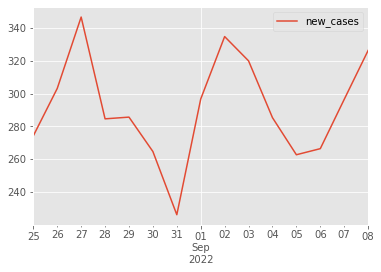

In [13]:
# future prediction
def predict_future(model,X,start_date='2020-01-01',timestep=10,future_step=30,):
    """
    Predict future values for X
    params:
        model: keras model
        X: input data for last timestep
        timestep: number of timesteps to predict
    """
    prediction = np.zeros(future_step)
    for i in range(future_step):
        v = X[-timestep:]
        prediction[i] = model.predict(v.reshape(1, -1),verbose=False)[0][0]
        X = np.append(X,prediction[i])
    prediction = pd.DataFrame(prediction, index=pd.date_range(start_date, periods=future_step, freq='D'), columns=['new_cases'])
    return prediction


last_ten = X_test[-1:]
print(last_ten.shape)
pred = predict_future(model,last_ten,start_date=df.index[-1],timestep=10,future_step=15)

pred.plot()
    